In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [22]:
DATA_DIR = "/content/gdrive/MyDrive/ds_Tharun/data"


In [26]:
CSV_DIR = '/content/gdrive/MyDrive/ds_Tharun/csv_files'
OUTPUT_DIR = '/content/gdrive/MyDrive/ds_Tharun/outputs'

In [27]:
import os
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [24]:
trades = pd.read_csv(f"{DATA_DIR}/trades.csv")
fear_greed = pd.read_csv(f"{DATA_DIR}/fear_greed.csv")

print("✅ Files loaded successfully!")
print("Trades shape:", trades.shape)
print("Fear/Greed shape:", fear_greed.shape)

✅ Files loaded successfully!
Trades shape: (211224, 16)
Fear/Greed shape: (2644, 4)


In [29]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
fear_greed.columns = fear_greed.columns.str.strip().str.lower().str.replace(" ", "_")

In [30]:
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], errors='coerce', format='%d-%m-%Y %H:%M')
fear_greed['date'] = pd.to_datetime(fear_greed['date'], errors='coerce')

In [31]:
trades['date'] = trades['timestamp_ist'].dt.date
fear_greed['date'] = fear_greed['date'].dt.date

In [32]:
# --- Step 6. Feature Engineering ---
trades['notional'] = trades['size_usd']
trades['is_win'] = trades['closed_pnl'] > 0

In [33]:
# --- Step 7. Aggregate daily metrics ---
daily = trades.groupby('date').agg(
    total_pnl=('closed_pnl','sum'),
    avg_execution_price=('execution_price','mean'),
    trade_count=('account','count'),
    avg_notional=('notional','mean'),
    win_rate=('is_win','mean')
).reset_index()

In [35]:
# --- Step 8. Merge with Fear & Greed Index ---
merged = pd.merge(daily, fear_greed[['date','classification','value']], on='date', how='left')
print("Merged dataset shape:", merged.shape)
display(merged.head())

Merged dataset shape: (480, 8)


,date,total_pnl,avg_execution_price,trade_count,avg_notional,win_rate,classification,value
0,2023-05-01,0.000000,1898.133333,3,159.000000,0.000000,Greed,63.0
1,2023-12-05,0.000000,11038.300000,9,5556.203333,0.000000,Extreme Greed,75.0
2,2023-12-14,-205.434737,8031.868818,11,10291.213636,0.363636,Greed,72.0
3,2023-12-15,-24.632034,2.982000,2,5304.975000,0.000000,Greed,70.0
4,2023-12-16,0.000000,0.384707,3,5116.256667,0.000000,Greed,67.0


In [36]:
merged.to_csv(f"{CSV_DIR}/merged_daily.csv", index=False)

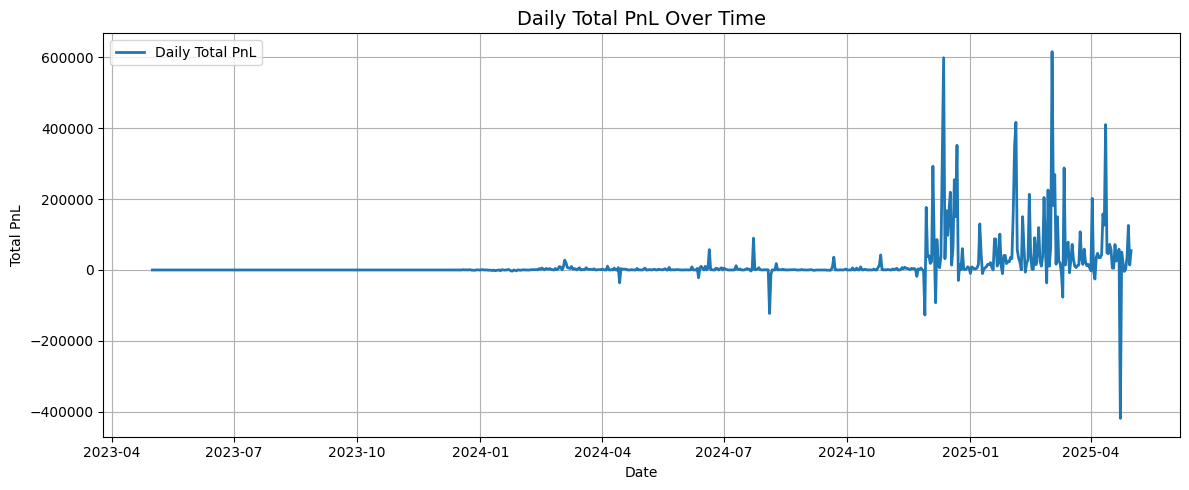

In [37]:
# --- Step 10. Visualization Section ---

# 1️⃣ Daily Total PnL trend
plt.figure(figsize=(12,5))
plt.plot(merged['date'], merged['total_pnl'], label='Daily Total PnL', linewidth=2)
plt.title('Daily Total PnL Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total PnL')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/pnl_trend.png")
plt.show()

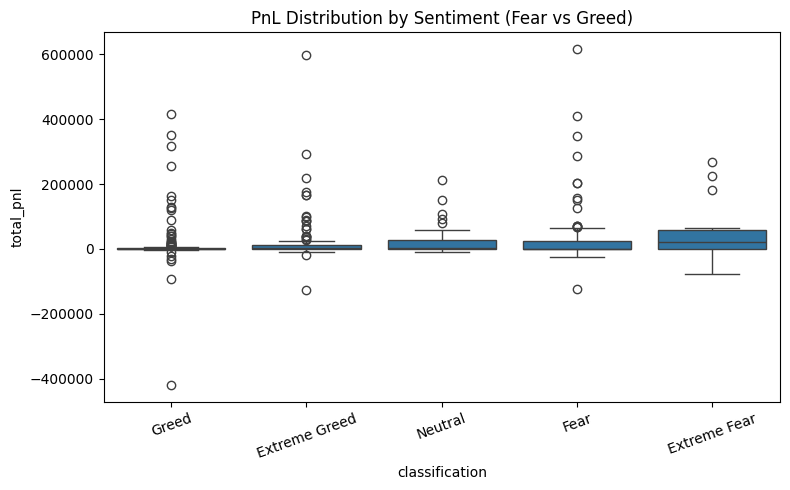

In [38]:
# 2️⃣ PnL Distribution by Sentiment
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='classification', y='total_pnl')
plt.title('PnL Distribution by Sentiment (Fear vs Greed)')
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/pnl_by_sentiment.png")
plt.show()

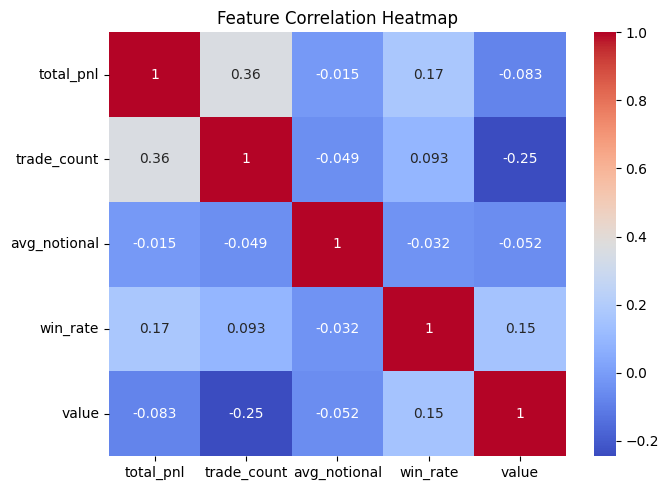

In [39]:
# 3️⃣ Correlation Heatmap
plt.figure(figsize=(7,5))
sns.heatmap(merged[['total_pnl','trade_count','avg_notional','win_rate','value']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/correlation_heatmap.png")
plt.show()

In [40]:
fear_pnl = merged.loc[merged['classification'].str.contains('Fear', case=False, na=False), 'total_pnl']
greed_pnl = merged.loc[merged['classification'].str.contains('Greed', case=False, na=False), 'total_pnl']

t_stat, p_val = ttest_ind(fear_pnl, greed_pnl, equal_var=False, nan_policy='omit')
print(f"📊 T-test between Fear vs Greed days:")
print(f"T-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")
if p_val < 0.05:
    print("✅ Statistically significant difference between Fear & Greed PnL")
else:
    print("ℹ️ No significant difference found")

📊 T-test between Fear vs Greed days:
T-statistic = 2.2727, p-value = 0.0246
✅ Statistically significant difference between Fear & Greed PnL


In [41]:
merged['sentiment_num'] = merged['classification'].map({
    'Extreme Fear': 0, 'Fear': 1, 'Neutral': 2, 'Greed': 3, 'Extreme Greed': 4
})
merged['profitable_day'] = merged['total_pnl'] > 0

X = merged[['sentiment_num','trade_count','avg_notional','win_rate','value']].fillna(0)
y = merged['profitable_day'].astype(int)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
acc = model.score(X_test,y_test)
print(f"🎯 Model Accuracy: {acc*100:.2f}%")

🎯 Model Accuracy: 88.54%


In [43]:
merged.to_csv(f"{CSV_DIR}/final_output.csv", index=False)
print("✅ All outputs exported successfully!")



✅ All outputs exported successfully!
